This shows a workthrough using cvxopt to perform a Lasso. cvxopt is very nice because it allows you to wrap in inequalities or constraints into your optimization. Say you have a system of linear equations 
\begin{align}
\mathbf{A\cdot x = y}.
\end{align}
$\mathbf{A}$ is an $m\times n$ matrix of independant variables, $\mathbf{y}$ is a vector of dependent measurements. You want to fit $\mathbf{x}$, but you want to avoid overfitting too many parameters. In such a scenario, you might minimize the objective function 
\begin{align}
O = \frac{1}{2m}\left ( \mathbf{A\cdot x - y} \right)^T \cdot \left ( \mathbf{A\cdot x - y} \right) - \lambda \sum_i^n |x_i|
\end{align}
The left term is a typical sum of squares objective function, the right term is called a Lasso penalty, with the strength of the penalty determined by $\lambda$. This problem is minimized by Python's sklearn.linear_model Lasso packages. I usually use cross-validation to learn the lasso penalty, but for this exercise I just want to see if the algorithm works. Let's make a toy underdetermined data set with more parameters than samples. Only 10 of the parameters will actually be predictive. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path, Lasso
import pylab

pylab.rcParams['font.size'] = 18

def lasso_scan(A,y, num_penalties=30, log_penalty_range=6):
    m = A.shape[0] 
    max_penalty = np.max(np.abs(- A.T.dot(y) / m)) # lambda should never be higher than this boundary
    max_penalty *= 10 # optional line, pads a little so that we can see changes in the Lasso stop affecting the model
    penalties = np.logspace(np.log10(max_penalty), 
                            np.log10(max_penalty)-log_penalty_range, 
                            num_penalties)#penalties to scan
    
    _ , coef_path, _ = lasso_path(A, y, alphas=penalties)
    
    return penalties, coef_path

np.random.seed(0)
m=100
n=500
A = np.random.randn(m,n)
x_true = np.random.randn(n)
x_true[10:] = 0
y = A.dot(x_true) + np.random.randn(m)*3.



And now let's scan it using sklearn lasso library as a control:

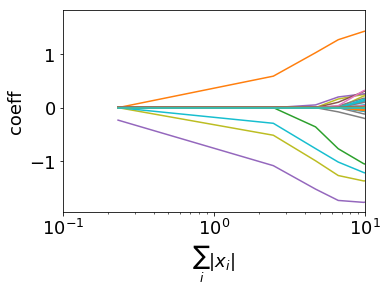

In [2]:
penalties, coeffs = lasso_scan(A,y)
fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.semilogx(np.sum(np.abs(coeffs.T), axis=1), coeffs.T)
ax.set_xlabel(r'$\sum_i |x_i|$')
ax.set_ylabel('coeff')
ax.set_xlim([1e-1,10])
plt.show()
plt.close()

OK, next, we want to try using cvxopt to analyze this. Let's see if it's up the challenge!

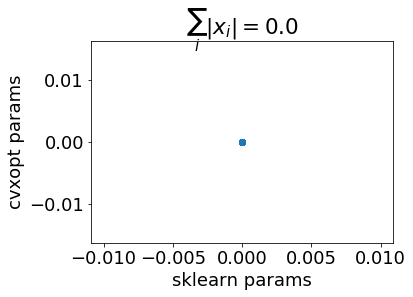

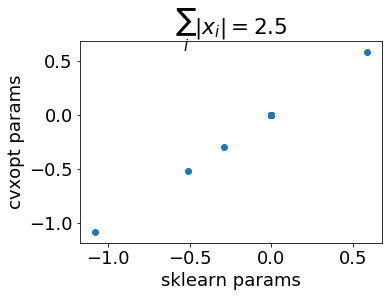

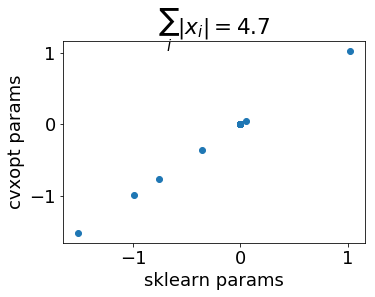

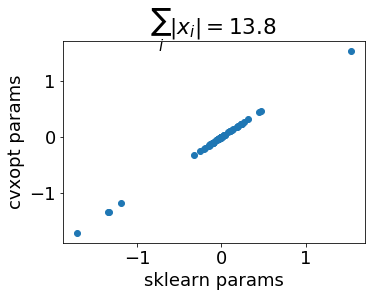

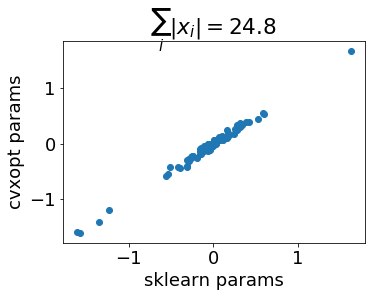

In [3]:
from cvxopt_lasso import monotonic_lasso
for ind in [3, 6, 7, 10, 20]:
    cvxopt_params = monotonic_lasso(A, y, np.sum(np.abs(coeffs[:, ind])))
    fig = plt.figure()
    ax = fig.add_axes([0.2,0.2,0.7,0.7])
    ax.scatter(coeffs[:,ind], cvxopt_params)
    ax.set_xlabel(r'sklearn params')
    ax.set_ylabel('cvxopt params')
    ax.set_title(r'$\sum_i |x_i|=%.1f$'%np.sum(np.abs(coeffs[:, ind])))
    plt.show()
    plt.close()


Looks pretty good at various lasso penalties. 

Next, I'm going to define a comparison function, which I'll describe the output of in the next couple of cells.

In [4]:
SSE = lambda x, y:np.sum((y.flatten()-x.flatten())**2)
sign_count = lambda x, y:np.sum(np.sign(x.flatten()) == np.sign(y.flatten()))

def plot_comparison(coeffs, A, x_true, y, no_lasso=[], param_order=[], rank_coeff=[]):
    if len(rank_coeff) == 0:
        rank_coeff = np.ones(A.shape[1])
    sklearn_SSE = []
    cvxopt_SSE = []
    sklearn_true_SSE = []
    cvxopt_true_SSE = []
    sklearn_correct_sign = []
    cvxopt_correct_sign = []
    lasso_constraint = []
    cvxopt_lasso_constraint = []
    for ind in range(coeffs.shape[1]):
        lasso_constraint.append(np.sum(np.abs(coeffs[:, ind])))
        cvxopt_params = monotonic_lasso(A, y, np.sum(np.abs(coeffs[:, ind])), no_lasso=no_lasso, param_ranks=param_order, rank_coeff=rank_coeff)

        cvxopt_lasso_constraint.append(np.sum(np.abs(cvxopt_params.flatten() * rank_coeff)))

        cvxopt_params[np.abs(cvxopt_params.flatten() * rank_coeff) < 1e-7] = 0 #cvxopt tends to have a lot numerical noise, so insist small numbers are 0

        sklearn_SSE.append(SSE(y,A.dot(coeffs[:, ind].flatten())))
        cvxopt_SSE.append(SSE(y,A.dot(cvxopt_params.flatten())))

        sklearn_true_SSE.append(SSE(x_true.flatten(), coeffs[:, ind].flatten() * rank_coeff))
        cvxopt_true_SSE.append(SSE(x_true.flatten(), cvxopt_params.flatten() * rank_coeff))

        cvxopt_params[np.abs(cvxopt_params) < 1e-7] = 0 #cvxopt tends to have a lot numerical noise, so insist small numbers are 0
        
        sklearn_correct_sign.append(sign_count(x_true, coeffs[:, ind].flatten() * rank_coeff))
        cvxopt_correct_sign.append(sign_count(x_true, cvxopt_params.flatten() * rank_coeff))

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_axes([0.2,0.2,0.7,0.7])
    ax.semilogy(cvxopt_lasso_constraint, cvxopt_SSE, label='cvxopt')
    ax.semilogy(lasso_constraint, sklearn_SSE, label='sklearn')
    plt.legend()
    ax.set_xlabel(r'$\sum_i |x_i|$')
    ax.set_ylabel('SSE')
    plt.show()
    plt.close()


    fig = plt.figure(figsize=(7,7))

    ax = fig.add_axes([0.2,0.2,0.7,0.7])
    ax.semilogy(cvxopt_lasso_constraint, cvxopt_true_SSE, label='cvxopt')
    ax.semilogy(lasso_constraint, sklearn_true_SSE, label='sklearn')

    plt.legend()
    ax.set_xlabel(r'$\sum_i |x_i|$')

    ax.set_ylabel('SSE of fit x to true x')
    plt.show()
    plt.close()


    fig = plt.figure(figsize=(7,7))

    ax = fig.add_axes([0.2,0.2,0.7,0.7])
    ax.plot(cvxopt_lasso_constraint, cvxopt_correct_sign , label='cvxopt')
    ax.plot(lasso_constraint, sklearn_correct_sign, label='sklearn')
    ax.set_ylim([450, 510])
    plt.legend()
    ax.set_xlabel(r'$\sum_i |x_i|$')

    ax.set_ylabel('# correct coeff signs')
    plt.show()
    plt.close()

The key thing about this function is that I can define multiple constraints on cvxopt, and compare how well it performs to sklearn's plain vanilla lasso fits. Let's compare the plain vanilla fits:

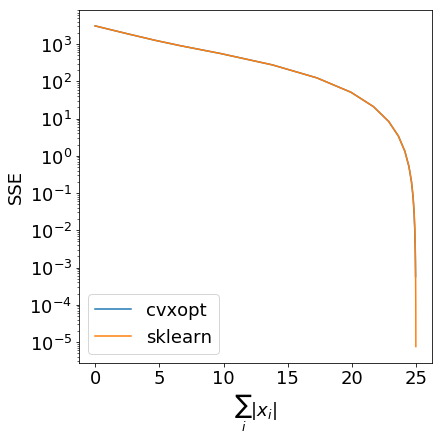

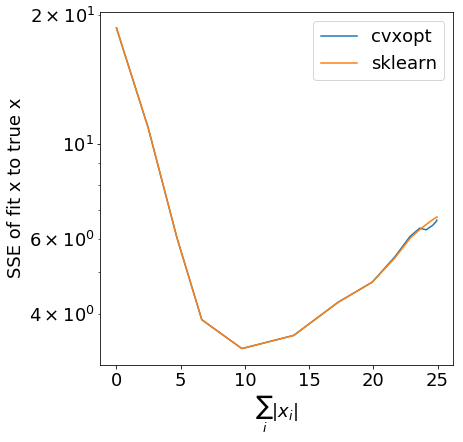

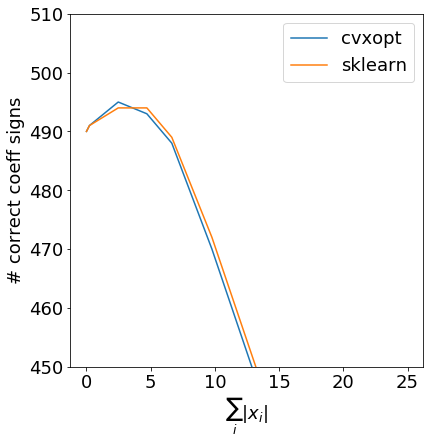

In [5]:
plot_comparison(coeffs, A, x_true, y, no_lasso=[], param_order=[])

For cvxopt, I can't really solve lasso in terms of the penalty, instead I am solving with the constrant that $\sum_i |x_i| \le c$. I've rearranged the x-axis to show this absolute sum instead of penalty. Each figure has an identical x-axis, but differs in the y-axis. The first plot shows the sum of square error of y to $\hat{y}$ as a function of the penalty rank. Lower is better. Similarly, the second plot shows how close the fit parameters are to the true parameters. Lower is again better. Finally, wrt lasso we often just care if the sign of the parameters is correct, using lasso as a parameter selection. The third plot shows how well lasso is getting the sign right. Higher is better in this case.


Beyond this point cvxopt can really shine. Say you want to drop the lasso penalty for some of your parameters that you know are relevant. cvxopt can handle this just fine. Let's allow the algorithm to go ahead and fit the first 5 parameters without the lasso penalty.

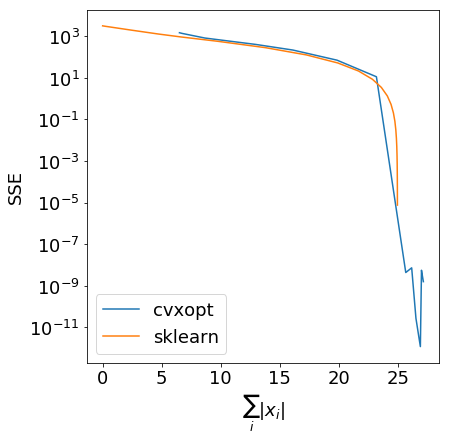

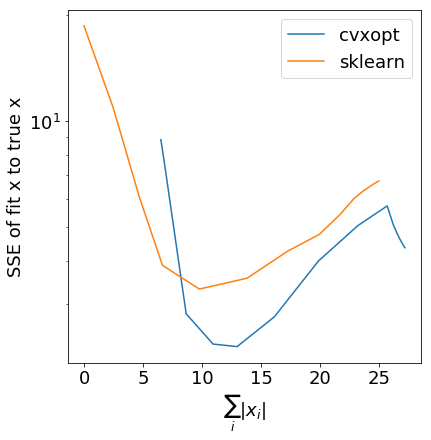

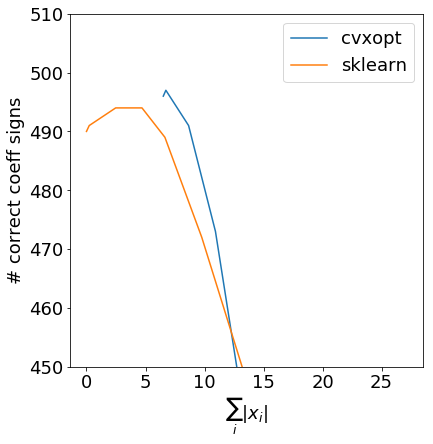

In [6]:
plot_comparison(coeffs[:,:30], A, x_true, y, no_lasso=range(5), param_order=[])

Neat! So if you know that some terms have to be fit regardless of lasso, you might be able to get slightly better results.

Instead, say you know from previous experiments the order of the parameters, but your current measurements are slightly different. You could enforce the order from your previous experience using cvxopt:

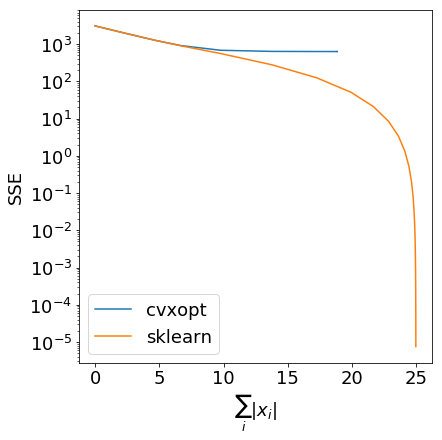

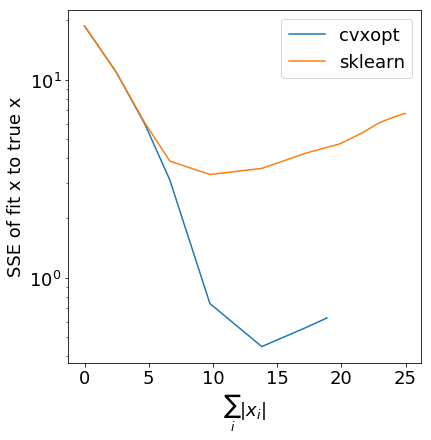

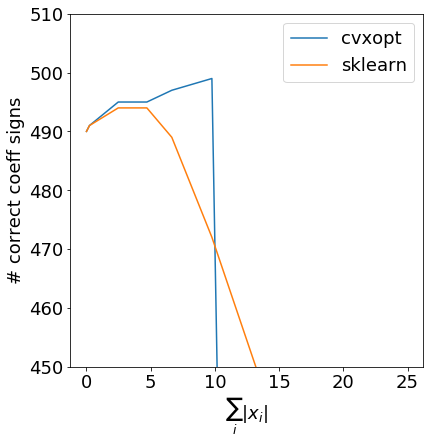

In [7]:
plot_comparison(coeffs[:,:30], A, x_true, y, no_lasso=[], param_order=np.argsort(x_true))

This gave a pretty massive improvement to the fit.

My cvxopt Lasso script also works with both lasso relaxed, and known order. Also, let's mess up the scaling and then reproduce it in the ordering.

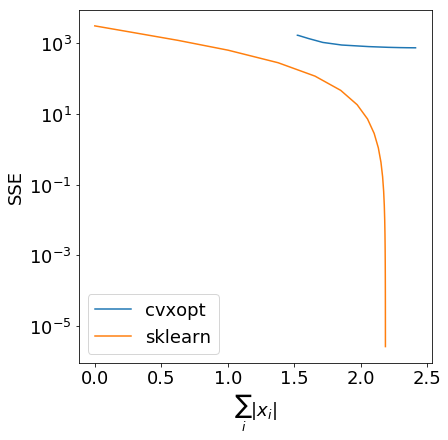

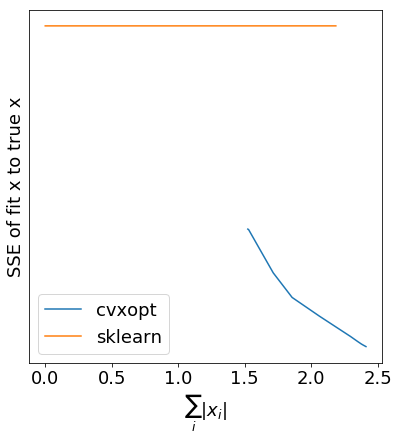

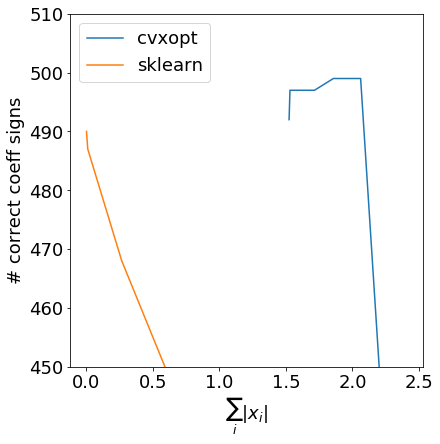

In [8]:
penalties, coeffs = lasso_scan(A * np.sqrt(np.arange(1,501)),y)
plot_comparison(coeffs, A * np.sqrt(np.arange(1,501)), x_true, y, param_order=np.argsort(x_true), rank_coeff= 1./np.sqrt(np.arange(1,501)), no_lasso=range(5))

This last example is a bit weird, but it could be useful if you standardize the data, but also want to maintain a certain order in your parameters. In this example it worked pretty well since I was deemphasizing the non-zero features in the fit. cvxopt was able to pick out the actual parameters much better than sklearn given this additional bit of knowledge that I passed to my cvxopt lasso function.


Conclusion time.  

I wrote a lasso solver using cvxopt, and even though it's not as efficient as sklearn's lasso solver for basic problems, I think it does offer a bit more flexibility for when you know additional information about the problem, and you want to incorporate these constraints into your problem. Having cvxopt's additional constraints can really make for some interesting analytical questions.